# Notebook para Análisis Matemático 2

La idea es ir agregándole herramientas a medida que se vayan aprendiendo. Más que nada es para ahorrarte o corroborar algunas cuentas.

Primero importamos las librerías que vamos a usar. La idea de esto es decirle a python que se tenga a mano algunas herramientas:

* `SymPy`: Es la que nos deja hacer cálculo simbólico. Con simbolitos. https://docs.sympy.org/
* `Matplotlib`: Es la que nos deja hacer gráficos. Llamamos en particular a pyplot porque es la que se usar y la más usada en general.https://matplotlib.org/stable/index.html
    * `mpl_toolkits`: Es una colección de módulos de funciones que le dan más versatilidad a matplotlib. De acá nos interesa en particular
    el módulo de ploteo en 3 dimensiones `mplot3D`. https://matplotlib.org/2.2.2/tutorials/toolkits/mplot3d.html
* `NumPy`: Es una que te permite hacer cuentas grandes de manera súper optimizada. Clave para cálculo numérico. https://numpy.org/doc/stable/

Al lado de la descripción de cada una están los links a sus páginas principales donde podés encontrar su documentación por si te surge alguna duda. Aconsejo pegarle una leída rápida al índice para ver qué onda y después, las dudas puntuales de porqué no funciona algo googlearlas directamente. 

In [100]:
# Esta línea es una línea mágica de jupyter. Hace que puedas hacerle zoom y mover los grafiquitos. Si escribís directamente
# en un script de python hay que sacarla
%matplotlib ipympl

# Acá sí importamos las librerías como corresponde
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm    # Le da color a los puntos de la superficie en base a su valor en z

## Extremos

Lo primero que hacemos es definir las cosas correctamente según Sympy

* Las variables las llamamos en una línea y las funciones en otra. 
* Las últimas tienen que tener el argumento cls=smp.Function. 
* Le decimos las variables de las que dependen.

Si querés podés agregar más funciones o variables acordándote de seguir el formato anterior.

In [ ]:
# Esto es un comentario. No se corre lo que le sigue al numeral y no afecta en nada al resto.
x,y,l = smp.symbols(r'x y \lambda', real=True)  # Fijate que puse r' ...' eso es para que me tome la letra griega lambda.
f, g = smp.symbols('f g', real=True, cls=smp.Function)
f = f(x,y); g=g(x,y)

Acá definí las funciones como te parezca. En esta notebook f es la función a estudiar y g el vínculo. Si querés otro vínculo acordate de declararlo en la celda anterior y después venís acá.

In [ ]:
f = 2*x**2 + y**4
g = x**2 + 2*y**2 - 8

In [ ]:
# Si escribís el nombre de una variable en la última línea de la celda, Jupyter te muestra
# que hay en esa variable. En este caso tiene a la función simbólica g definida como en la 
# celda anterior.
g

x**2 + 2*y**2 - 8

### Gradiente y extremos locales

En la siguiente celda calculamos el gradiente de las funciones.

* `smp.diff()` es la función que hace el trabajo.
* Si tu función depende de más variables fijate de cambiar eso acá también. El único cambio que habría que hacer es agregarle las variables nuevas a la lista "var".
* Notación de Python: las cosas que ponemos entre corchetes se llaman listas. Ej: lista_de_ej = [1, 2, 3]

In [ ]:
# Si en vez de x,y tengo una función que depende de x,y,z; la línea de abajo debería decir
# var = [x,y,z]
var = [x,y]

# Las líneas que siguen quedarían igual. Si tenés una restricción más, podés definirle e
# gradiente de la misma manera. Ej: si tenés una función de vínculo h, escribís:
# grad_h = [smp.diff(h, u) for u in var]

grad_f = [smp.diff(f, u) for u in var]
grad_g = [smp.diff(g, u) for u in var]
grad_f

[4*x, 4*y**3]

In [ ]:
candidatos_locales = smp.solve(grad_f, (x,y))
candidatos_locales

[(0, 0)]

### Hessiana

Es la misma idea que el gradiente solo que ahora derivás al gradiente que calculaste antes.

* En el caso de tener 3 variables en vez de 2, lo único que tenés que cambiar es el límite superior de la variable i (se explica mejor en la celda)
* `smp.Matrix()`: a esta función le das de comer una lista y te devuelve una matriz con el formato lindo ese que se ve.
    * Además es necesaria porque para el método de Sylvester te interesa calcularle el determinante después.
    * También podés usar el método de los autovectores y autovalores muy rápido con el método .eigenvects()

Si te pinta resolver como calcular los menores con Python podés mirar las herramientas que hay para matrices acá https://docs.sympy.org/latest/tutorials/intro-tutorial/matrices.html

In [ ]:
# Si en vez de 2, tenés n variables, donde dice for i in [0,1], escribí: for i in [0, n-1]
hess_f = smp.Matrix([[smp.Rational(1,2)*smp.diff(grad_f[i], u) for u in var] for i in [0,1]])
hess_f

Matrix([
[2,      0],
[0, 6*y**2]])

#### Criterio de Sylvester

Para el caso de una función real de dominio $\mathbb{R}^2$ y diferenciable en $(x_0,y_0)$, este criterio nos dice que
* Si $H_{11}(x_0,y_0) > 0$ y $|H(x_0,y_0)|>0$ entonces $f$ tiene un mínimo local en (x_0,y_0).
* Si $H_{11}(x_0,y_0) > 0$ y $|H(x_0,y_0)|<0$ entonces $f$ tiene un mínimo local en (x_0,y_0).
* Si $H_{11}(x_0,y_0) \le 0$ o $|H(x_0,y_0)|=0$ entonoces el criterio no decide nada.

In [ ]:
subs = [[(var[i], candidatos_locales[j][i]) for i in range(len(var))] for j in range(len(candidatos_locales))]
H_11_eval_en_cand = [hess_f[0].subs(subs[i]) for i in range(len(subs))]
det_H_eval_en_cand = [hess_f.det().subs(subs[i]) for i in range(len(subs))]
testarudos = []
max_loc, min_loc = [], []

for i in range(len(candidatos_locales)):
    if (H_11_eval_en_cand[i]*det_H_eval_en_cand[i] == 0 or H_11_eval_en_cand[i]<0):
        print('Acá no se qué decirte :(')
        testarudos.append(candidatos_locales[i])
        continue
    elif (det_H_eval_en_cand[i]>0):
        min_loc.append(candidatos_locales[i])
    else:
        max_loc.append(candidatos_locales[i])

Acá no se qué decirte :(


#### Criterio de los autovalores (este no falla) COMPLETAR

In [ ]:
# .eigenvects() te devuelve una lista de tuplas de la forma
# (autovector, multiplicidad algebraica, lista de autovectores)
# También existe el método .eigenvals() que te devuelve una lista de autovalores.
# Calcular los autovectores le cuesta más a la compu, pero eso empieza a ser relevante 
# para matrices mucho más grandes de las que vamos a tratar acá. Solo lo comento como
# curiosidad.
hess_f.eigenvects()

[(2,
  1,
  [Matrix([
   [1],
   [0]])]),
 (6*y**2,
  1,
  [Matrix([
   [0],
   [1]])])]

### Multiplicadores de Lagrange. Extremos con restricciones

Hasta acá sabemos que tenemos una función f con una restricción g. Queremos resolver el sistema

$$
\begin{cases}
\nabla f - \lambda \nabla g = 0 \\
g = 0
\end{cases}
$$

Para eso el plan de acción es armar el sistema de ecuaciones como una lista, donde cada elemento es una de las ecuaciones. Es clave tener en cuenta que los resolvedores solo manejan ecuaciones homogéneas, por eso definí al sistema y a la restricción de esa manera.

In [ ]:
# Armamos el sistema de ecuaciones.
# Si en vez de dos variables tenés n, acordate de hacer el cambio de [0,1] a [0, n-1] en la línea que sigue.

lagrange = [grad_f[i] - l*grad_g[i] for i in [0,1]]  # Primeras dos ecuaciones.
lagrange.append(g)                                   # Le agrego a la lista el vínculo.
lagrange                                             # Mostramos el sistema completo.

[-2*\lambda*x + 4*x, -4*\lambda*y + 4*y**3, x**2 + 2*y**2 - 8]

El resolvedor que vamos a usar es smp.solve(). 

Recibe como parámetros:

1) El sistema de ecuaciones (homogéneo) a resolver. Es una lista. Capaz también una matriz, no me acuerdo.
2) Una tupla (encierra elementos entre corchetes) con las variables a despejar.
    * Fijate que le paso a $\lambda$ como variable también para que me diga que valor toma. Importante esto.
    * En caso de tener más variables tu sistema de ecuaciones (variable lagrange definida en la celda anterior) debería tener más ecuaciones. El único cambio que habría que hacer en esta celda es agregarle las variables nuevas a la tupla de variables.
    
Te devuelve:

* Una lista con tuplas de valores que resuelven el sistema.
* Las tuplas están ordenadas. Es decir van a tener el mismo orden que vos le pasaste a la función como argumento.

In [ ]:
# Vamos a guardar la lista de tuplas solución en una variable que llamamos
# lagr_sols ¿Por qué? porque se puede y porque capaz que más adelante las quiero
# usar para algo. Me parece una buena práctica guardarlas así.
lagr_sols = smp.solve(lagrange, (x,y,l))
lagr_sols

[(-2, -sqrt(2), 2),
 (-2, sqrt(2), 2),
 (0, -2, 4),
 (0, 2, 4),
 (2, -sqrt(2), 2),
 (2, sqrt(2), 2),
 (-2*sqrt(2), 0, 2),
 (2*sqrt(2), 0, 2)]

### Evaluar en los candidatos para obtener los extremos

In [ ]:
# Acá voy a preparar la lista de tuplas que necesito para hacer la evaluación de f en estos puntos.

sustituciones = [[(var[i], lagr_sols[j][i]) for i in range(len(var))] for j in range(len(lagr_sols))]
sustituciones

candidatos = [f.subs(sustituciones[i]) for i in range(len(lagr_sols))]  # Hago una lista con las imágenes de los candidatos a extremo
minimo, maximo = min(candidatos), max(candidatos)                       # Me fijo cuál es el valor máximo y mínimo

# Acá hago dos listas, donde cada elemento contiene una lista con los extremos y su imágen.

minimos, maximos = [], []
for i in range(len(candidatos)):
    if (candidatos[i] == minimo):
        minimos.append([sustituciones[i], candidatos[i]])
    elif (candidatos[i] == maximo):
        maximos.append([sustituciones[i], candidatos[i]])
        
minimos

[[[(x, -2), (y, -sqrt(2))], 12],
 [[(x, -2), (y, sqrt(2))], 12],
 [[(x, 2), (y, -sqrt(2))], 12],
 [[(x, 2), (y, sqrt(2))], 12]]

## Curvas en el espacio

Lo primero que vamos a hacer es graficar curvas en el espacio tridimensional. Para eso vamos a usar el módulo `mpl_toolkits.mplot3d` de `matplotlib` (ya lo importamos en la primera celda de código de esta notebook).

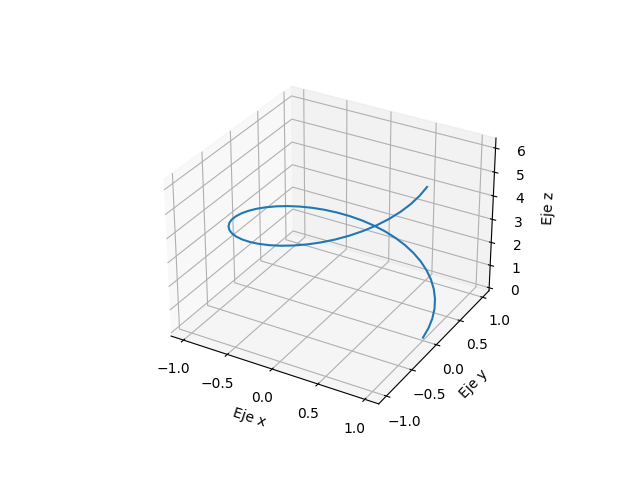

In [21]:
# Con esto creamos el sistema de coordenadas donde vamos a graficar
fig = plt.figure()
ax = plt.axes(projection='3d')

# Como queremos curvas parametrizadas en el espacio vamos a definir nuestro parámetro t.
# Este vendría a ser el dominio de la relación cuya gráfica es la que vamos a ver.
t = np.linspace(0, 2*np.pi, 50)   # Mirá como usarla acá https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

# Ahora vamos a definir nuestras componentes en función de t
x = np.cos(t)
y = np.sin(t)
z = t

# Ahora vamos a dibujar la curva en el sistema de coordenadas que creamos antes
ax.plot3D(x,y,z)
ax.set_xlabel('Eje x')
ax.set_ylabel('Eje y')
ax.set_zlabel('Eje z')    # Estas últimas tres líneas escriben el nombre de los ejes que queramos. No son estrictamente necesarias.

plt.show()                # Con esta línea le decimos a python que nos muestre el gráfico. No es estrictamente necesario en jupyterlab.

>**Aclaración importante**: Hasta ahora ploteamos con el sistema de coordenadas cartesiano. Está bueno pensar qué habría que hacer para cambiarle enetramado al espacio y graficar curvas usando coordenadas que no sean las cartesianas de toda la vida.

## Superficies en el espacio

Ahora vamos a graficar superficies parametrizables en el espacio. Es masomenos parecido a las curvas solo que ahora tenemos dos parámetros en vez de uno. 

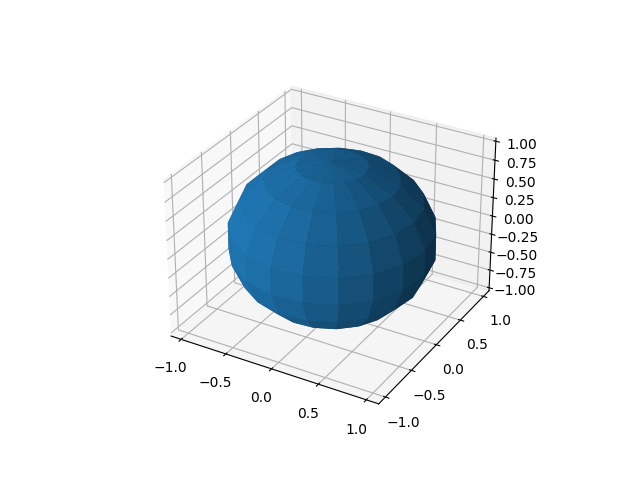

In [230]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Parámetros. Los vamos a crear con el objeto np.mgrid[val_inicial:val_final:cantidad de puntos, lo mismo pero para la sgunda dimension]
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# Armo la data
X = np.cos(u)*np.sin(v)
Y = np.sin(u)*np.sin(v)
Z = np.cos(v)

# Ploteamos la superficie. Si le sacamos la propiedad de cmap, la superficie se ve de un color sólido. 
surf = ax.plot_surface(X, Y, Z)

plt.show()

Esto solo nos permite graficar superficies cuyas regiones sean rectangulares. Por ejemplo para la esfera, la región es un rectángulo de lados $\pi$ y $2\pi$ respectivamente.

Para los otros casos, la idea es agarrar una región rectangular que contenga a la que es irrregular y después "filtrar" los que no pertenecen a la región irregular. Esa idea de filtrar la vamos a hacer reemplazando a los filtrados por `np.nan` que no son graficados por matplotlib.

Por ejemplo, si mi región es el triángulo 

$$
0<x<3\\
0<y<2x,
$$

y nuestra superficie es de la forma $\sigma(x,y) = (x,y,x^2+y^2)$, lo que hacemos es lo siguiente

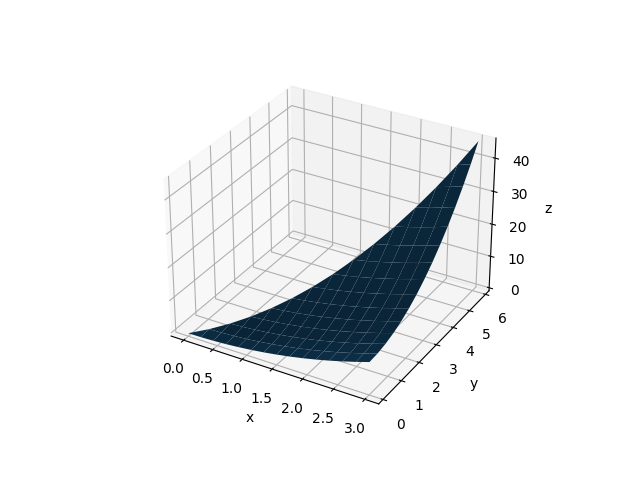

In [244]:
# Encontramos los valores máximos de ambas variables. En este caso x está entre 0 y 3, mientras que y está entre 0 y 6.
# Armamos la malla rectangular que contiene al triángulo que nos interesa.
x, y = np.mgrid[0:3:15j, 0:6:15j]

# Ahora toca filtrar las mallas. Alcanza con filtrar una. Como tenemos y=y(x) vamos a filtrar a la variable y.
# Para eso vamos a usar la función np.where(), que toma como primer argumento la condición que tienen que cumplir los
# valores para permanecer en la malla. El segundo argumento es la malla a filtrar, y el tercer elemento es el valor con 
# el que vamos a reemplazar a los filtrados. Este último argumento es más interesante pero por ahora nos sirve solo para 
# eso que te digo. Dejo el link igual https://numpy.org/doc/stable/reference/generated/numpy.where.html#numpy.where
y = np.where(y <= 2*x, y, np.nan)

# Ahora solo queda definir a la variable z=z(x,y).
z = x**2 + y**2

# Ploteamos la superficie como siempre.
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_ylim((-0.1, 6.1))
ax.plot_surface(x,y,z)

## Campos vectoriales en el espacio

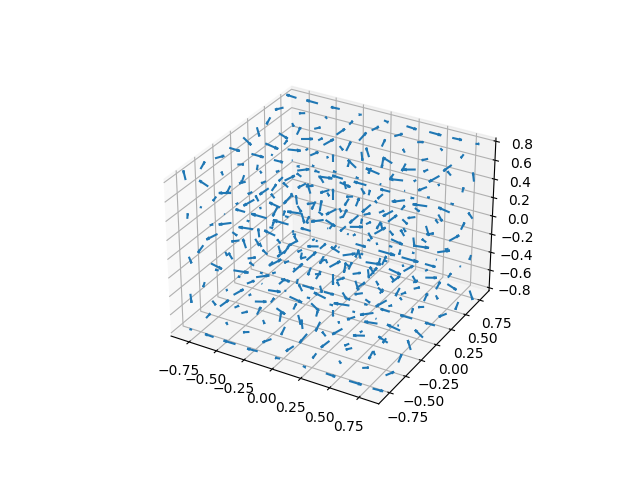

In [246]:
# Con esto creamos el sistema de coordenadas donde vamos a graficar
fig = plt.figure()
ax = plt.axes(projection='3d')

# Primero le especificamos el dominio del campo. En este caso como nos interesa ver el campo en general, usamos
# una función de numpy que se llama meshgrid(). Esta lo que hace es agarrar tres espacios unidimensionales y 
# "pegarlos" de la misma manera que agarrás los ejes x,y,z para hacer R3. Esa operación se llama producto cartesiano.
# arange() me devuelve un array de números cuya separación se la tengo que decir yo también.
x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.4))

# Acá tenemos que escribir las componentes del campo vectorial que queremos dibujar
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

# Ahora dibujamos nuestro campo en el sistema de coordenadas
ax.quiver(x, y, z, u, v, w, length=0.15)    # Mirá más de cómo usarla acá https://matplotlib.org/2.2.2/tutorials/toolkits/mplot3d.html#quiver

plt.show()

Es interesante ver qué pasa cuando acotamos el dominio del campo vectorial a solo una curva en el espacio. Esto nos puede servir para visualizar lo que estamos "sumando" cuando hacemos una integral de trayectoria. Para eso vamos a usar la curva y campo que definimos antes. Vos cambiale lo que quieras.

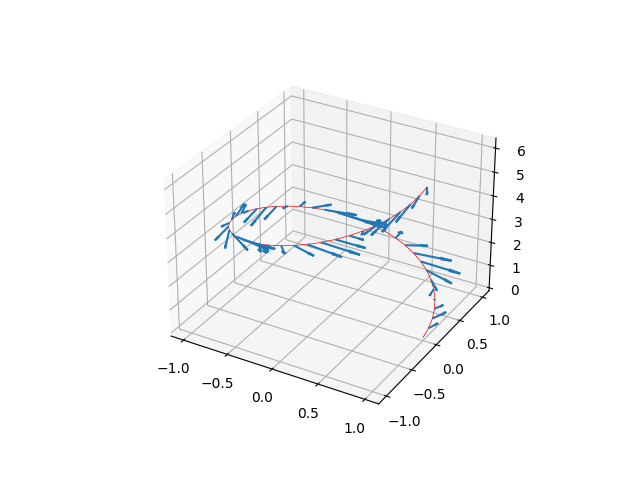

In [55]:
# Con esto creamos el sistema de coordenadas donde vamos a graficar
fig = plt.figure()
ax = plt.axes(projection='3d')

# Parametrizamos la curva
t = np.linspace(0, 2*np.pi, 50)
x = np.cos(t)
y = np.sin(t)
z = t

# Definimos el campo
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

# Graficamos la curva y el campo con el dominio acotado a la curva
ax.plot3D(x,y,z, lw=0.5, color='red')
ax.quiver(x, y, z, u, v, w, length=0.5)

plt.show()

Claramente ahora le toca a las integrales de flujo. Para eso necesitamos una superficie y un campo vectorial. Cuando hacemos la integral de flujo lo que estamos "sumando" es la cantidad de campo que sale normal a la superficie. Para ver eso vamos a reciclar el campo y las superficies previamente definidas. 

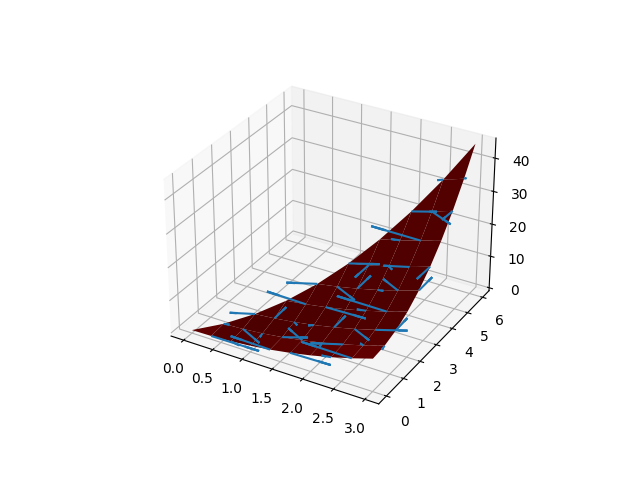

In [259]:
# Con esto creamos el sistema de coordenadas donde vamos a graficar
fig = plt.figure()
ax = plt.axes(projection='3d')

# Parametrizamos la superficie
x, y = np.mgrid[0:3:10j, 0:6:10j]
y = np.where(y <= 2*x, y, np.nan)
z = x**2 + y**2

# Definimos el campo
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

# Graficamos la curva y el campo con el dominio acotado a la curva
ax.plot_surface(x,y,z, color='red')
ax.quiver(x, y, z, u, v, w)

plt.show()

Quizás no es el mejor ejemplo porque el campo es bastante choto, pero bueno, vos cambiale lo que haya que cambiar con las cosas de la práctica.